In [564]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load train dataset
df = pd.read_csv('train_dataset_final1.csv')
df.head()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,63.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


In [565]:
print(df.shape)
print(df.info())
print(df.describe())

(25247, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25247 entries, 0 to 25246
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         25247 non-null  int64  
 1   marriage            25247 non-null  int64  
 2   sex                 25247 non-null  int64  
 3   education           25247 non-null  int64  
 4   LIMIT_BAL           25247 non-null  int64  
 5   age                 25121 non-null  float64
 6   pay_0               25247 non-null  int64  
 7   pay_2               25247 non-null  int64  
 8   pay_3               25247 non-null  int64  
 9   pay_4               25247 non-null  int64  
 10  pay_5               25247 non-null  int64  
 11  pay_6               25247 non-null  int64  
 12  Bill_amt1           25247 non-null  float64
 13  Bill_amt2           25247 non-null  float64
 14  Bill_amt3           25247 non-null  float64
 15  Bill_amt4           25247 non-null  float

In [566]:
# Missing values
print(df.isnull().sum())

# Unique values in categoricals
for col in ['sex', 'education', 'marriage']:
    print(col, df[col].unique())

#in age replace nulls with mean
df['age'].fillna(df['age'].mean(), inplace=True)

Customer_ID             0
marriage                0
sex                     0
education               0
LIMIT_BAL               0
age                   126
pay_0                   0
pay_2                   0
pay_3                   0
pay_4                   0
pay_5                   0
pay_6                   0
Bill_amt1               0
Bill_amt2               0
Bill_amt3               0
Bill_amt4               0
Bill_amt5               0
Bill_amt6               0
pay_amt1                0
pay_amt2                0
pay_amt3                0
pay_amt4                0
pay_amt5                0
pay_amt6                0
AVG_Bill_amt            0
PAY_TO_BILL_ratio       0
next_month_default      0
dtype: int64
sex [0 1]
education [2 1 3 4 5 6 0]
marriage [2 1 3 0]


C:\Users\krish\AppData\Local\Temp\ipykernel_113168\1185568460.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].mean(), inplace=True)


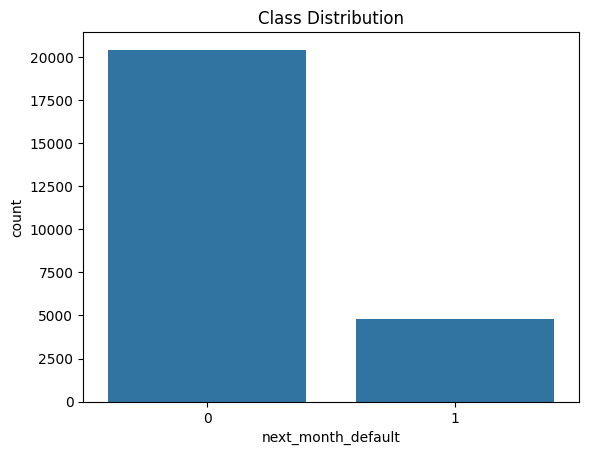

next_month_default
0    0.809601
1    0.190399
Name: proportion, dtype: float64


In [567]:
# Target variable distribution
sns.countplot(x='next_month_default', data=df)
plt.title("Class Distribution")
plt.show()

print(df['next_month_default'].value_counts(normalize=True))

# -> 20% of users are likely to default next month

Total rows in the dataset: 25247


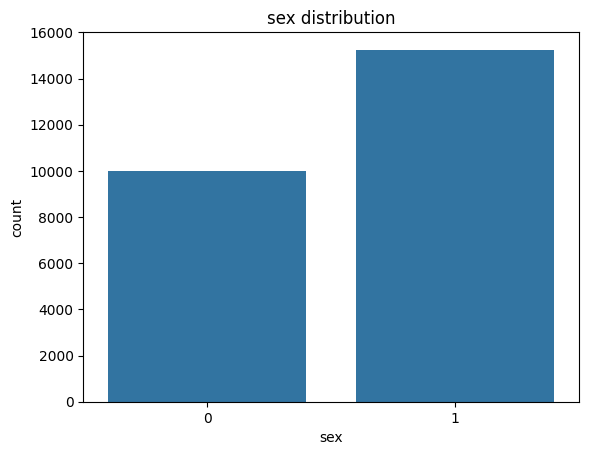

sex unique values: [0 1]
sex
1    60.411138
0    39.588862
Name: proportion, dtype: float64
sex
1    15252
0     9995
Name: count, dtype: int64


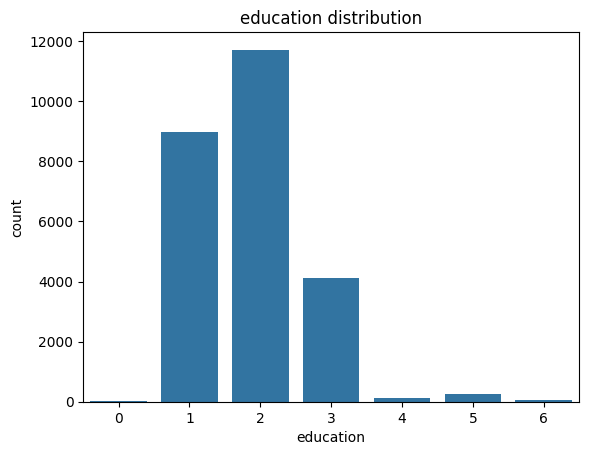

education unique values: [2 1 3 4 5 6 0]
education
2    46.409474
1    35.600269
3    16.298966
5     1.002099
4     0.459461
6     0.174278
0     0.055452
Name: proportion, dtype: float64
education
2    11717
1     8988
3     4115
5      253
4      116
6       44
0       14
Name: count, dtype: int64


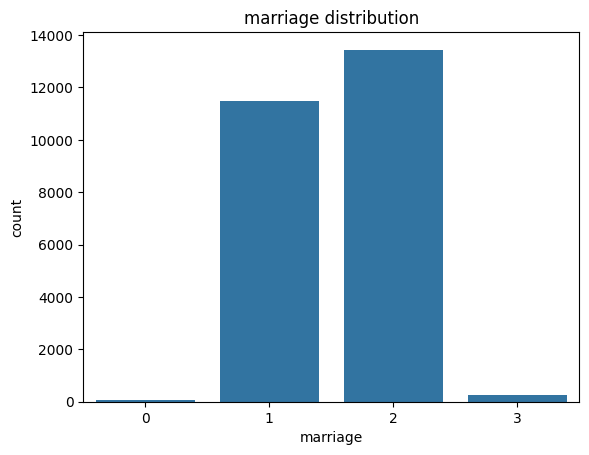

marriage unique values: [2 1 3 0]
marriage
2    53.238008
1    45.470749
3     1.081317
0     0.209926
Name: proportion, dtype: float64
marriage
2    13441
1    11480
3      273
0       53
Name: count, dtype: int64


In [568]:
categorical_cols = ['sex', 'education', 'marriage']

#print total rows in the dataset
print("Total rows in the dataset:", len(df))

for col in categorical_cols:
    sns.countplot(x=col, data=df)
    plt.title(f'{col} distribution')
    plt.show()
    print(f"{col} unique values:", df[col].unique())
    #print percentage of each category
    print(df[col].value_counts(normalize=True) * 100)
    #print count of each category
    print(df[col].value_counts())

# 297 outliers for education
# 273 outliers for marriage
# Very less married people in the dataset -> only 53 out of 25247

# in marriage replace 3+ with median of 0,1,2
df['marriage'] = df['marriage'].replace(0, 3)

#in edu replace 3+ with median of 0,1,2
df['education'] = df['education'].replace(0, 4)
df['education'] = df['education'].replace(5, 4)
df['education'] = df['education'].replace(6, 4)


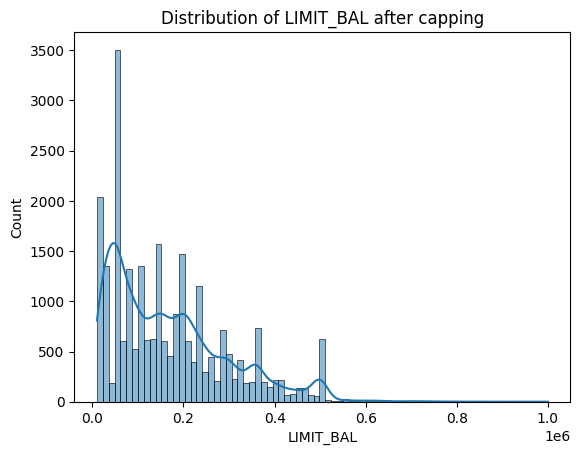

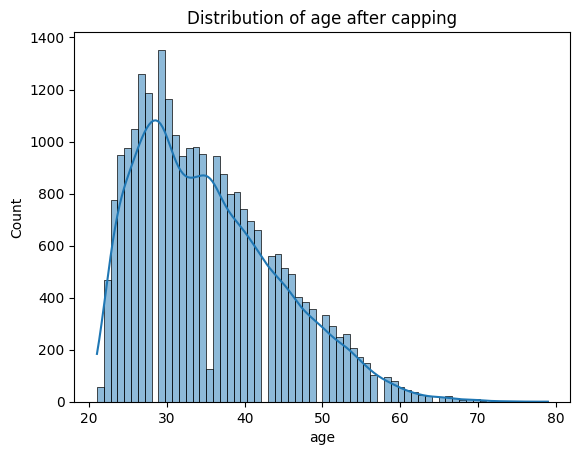

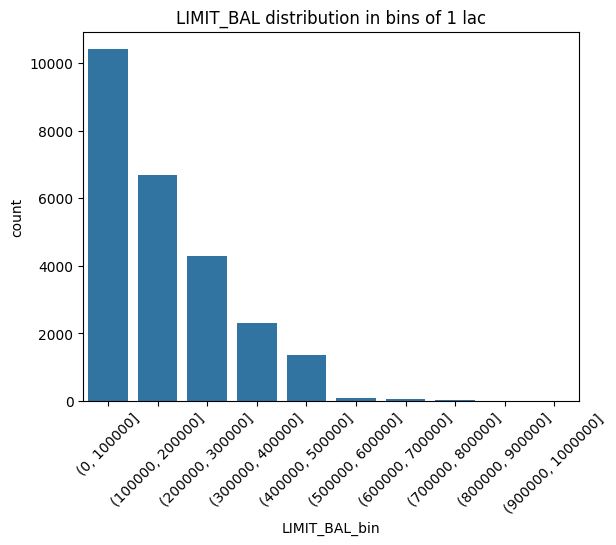

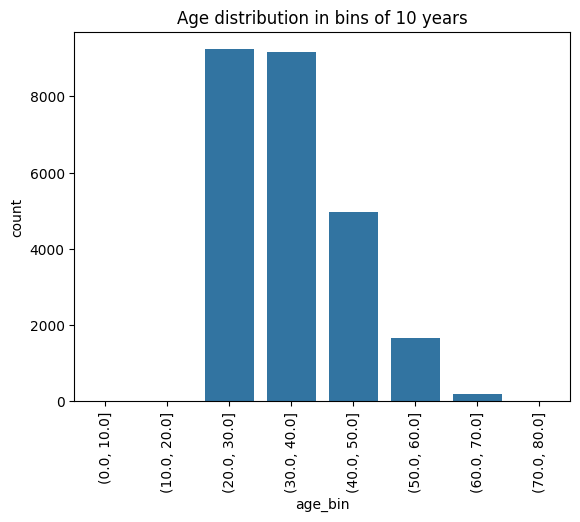

Shape after dropping outliers: (24199, 29)


In [569]:
static_numerics = ['LIMIT_BAL', 'age']

# for col in static_numerics:
#     sns.histplot(df[col], kde=True)
#     plt.title(f'Distribution of {col}')
#     plt.show()

#Both are right-skewed distributions
#Checking for outliers in static numerics

# for col in static_numerics:
#     sns.boxplot(x=df[col])
#     plt.title(f'Boxplot of {col}')
#     plt.show()
#     print(f"{col} outliers:", df[col][df[col] > df[col].quantile(0.99)].count())


#do capping in df itself
# for col in static_numerics:
#     df[col] = np.where(df[col] > df[col].quantile(0.95), df[col].quantile(0.95), df[col])
#     print(f"After capping, {col} shape: {df[col].shape}")



# now plot
for col in static_numerics:
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col} after capping')
    plt.show()


#for limit_bal, print counts in bin size of 1lac
df['LIMIT_BAL_bin'] = pd.cut(df['LIMIT_BAL'], bins=np.arange(0, df['LIMIT_BAL'].max() + 100000, 100000))
sns.countplot(x='LIMIT_BAL_bin', data=df)
plt.title('LIMIT_BAL distribution in bins of 1 lac')
plt.xticks(rotation=45)
plt.show()
# for age, print counts in bin size of 10 years
df['age_bin'] = pd.cut(df['age'], bins=np.arange(0, df['age'].max() + 10, 10))
sns.countplot(x='age_bin', data=df)
plt.title('Age distribution in bins of 10 years')
plt.xticks(rotation=90)
plt.show()


# drop 5 lac + and 60+ age

df = df[(df['LIMIT_BAL'] < 500000) & (df['age'] < 60)]
print("Shape after dropping outliers:", df.shape)




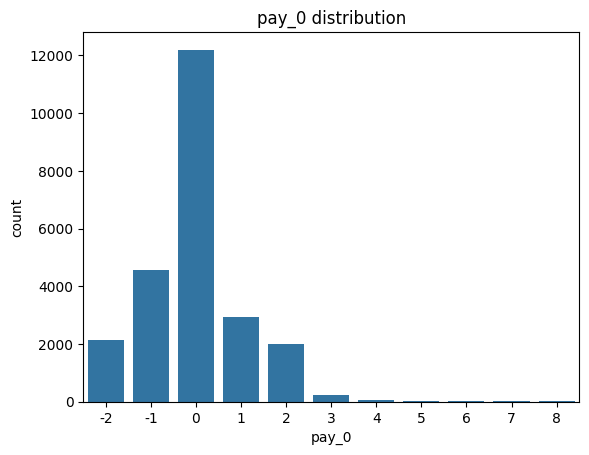

pay_0 unique values: [ 2  0 -2 -1  1  8  4  3  5  6  7]
pay_0 value counts:
 pay_0
 0    12195
-1     4580
 1     2933
-2     2155
 2     1992
 3      238
 4       55
 5       21
 8       14
 6        8
 7        8
Name: count, dtype: int64


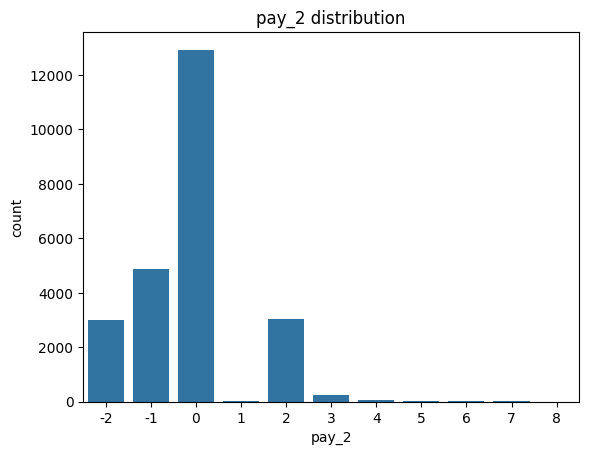

pay_2 unique values: [ 2  0 -2 -1  7  4  3  1  5  6  8]
pay_2 value counts:
 pay_2
 0    12928
-1     4859
 2     3031
-2     3002
 3      235
 4       76
 1       22
 5       19
 7       15
 6       11
 8        1
Name: count, dtype: int64


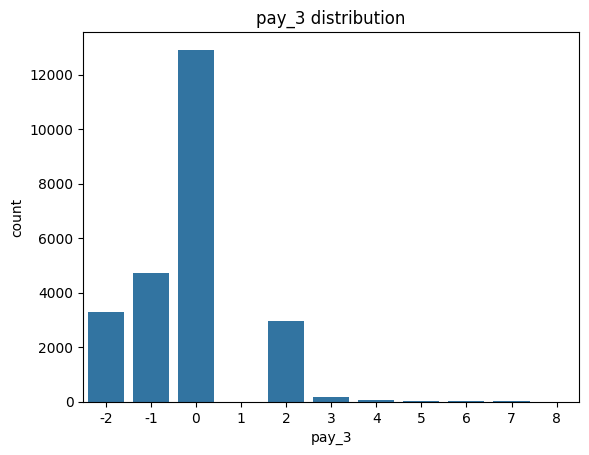

pay_3 unique values: [ 2 -2  0 -1  6  3  4  1  7  5  8]
pay_3 value counts:
 pay_3
 0    12914
-1     4737
-2     3282
 2     2978
 3      175
 4       56
 7       18
 5       18
 6       17
 1        3
 8        1
Name: count, dtype: int64


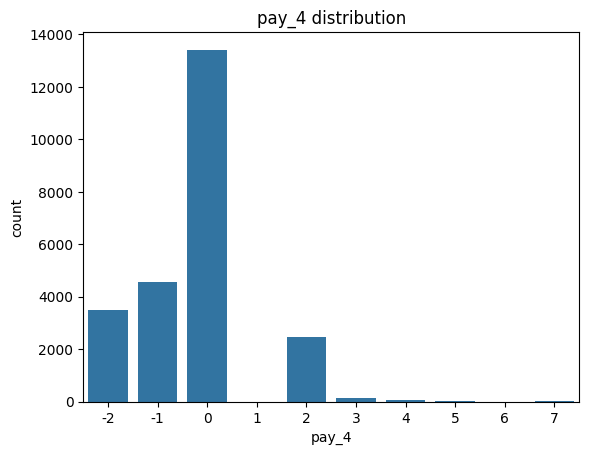

pay_4 unique values: [ 0 -2 -1  2  5  3  4  7  6  1]
pay_4 value counts:
 pay_4
 0    13416
-1     4570
-2     3491
 2     2459
 3      136
 4       51
 7       42
 5       29
 6        4
 1        1
Name: count, dtype: int64


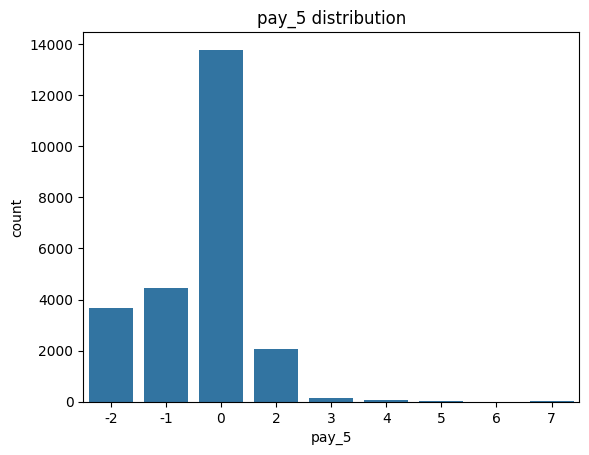

pay_5 unique values: [ 0 -1 -2  2  4  3  6  7  5]
pay_5 value counts:
 pay_5
 0    13774
-1     4446
-2     3659
 2     2061
 3      133
 4       69
 7       42
 5       14
 6        1
Name: count, dtype: int64


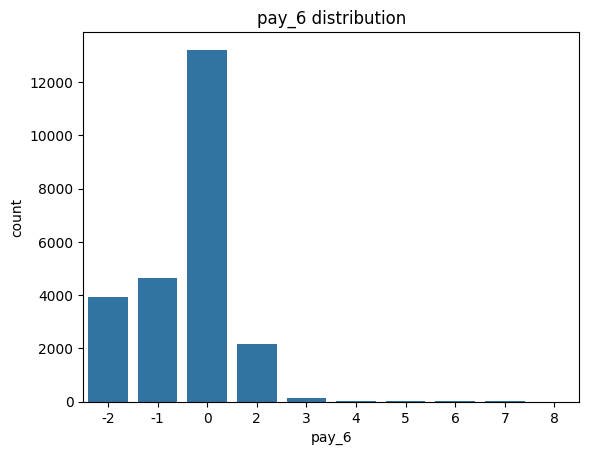

pay_6 unique values: [ 0 -2 -1  2  3  4  5  7  6  8]
pay_6 value counts:
 pay_6
 0    13221
-1     4630
-2     3935
 2     2184
 3      134
 4       38
 7       33
 6       13
 5       10
 8        1
Name: count, dtype: int64


In [570]:
pay_status_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

for col in pay_status_cols:
    sns.countplot(x=col, data=df)
    plt.title(f'{col} distribution')
    plt.show()
    print(f"{col} unique values:", df[col].unique())
    print(f"{col} value counts:\n", df[col].value_counts())
    

Shape after dropping outliers: (24199, 29)
✅ Shape after filtering: (21590, 29)


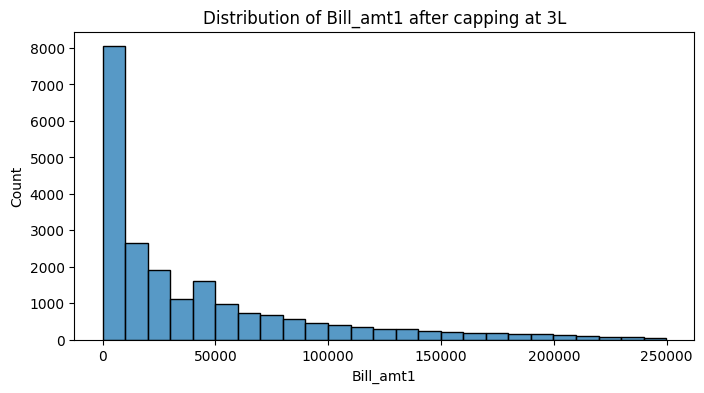

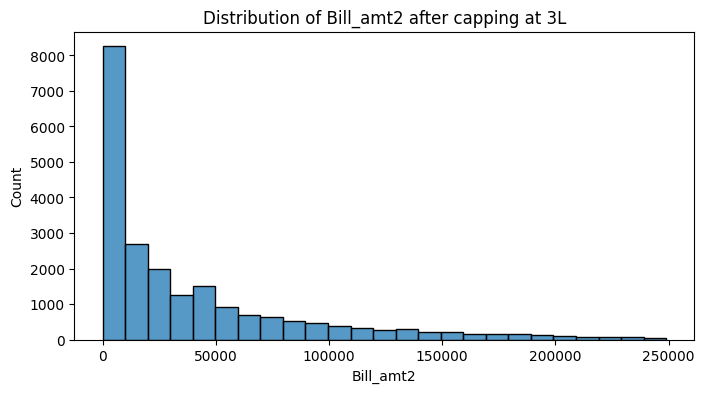

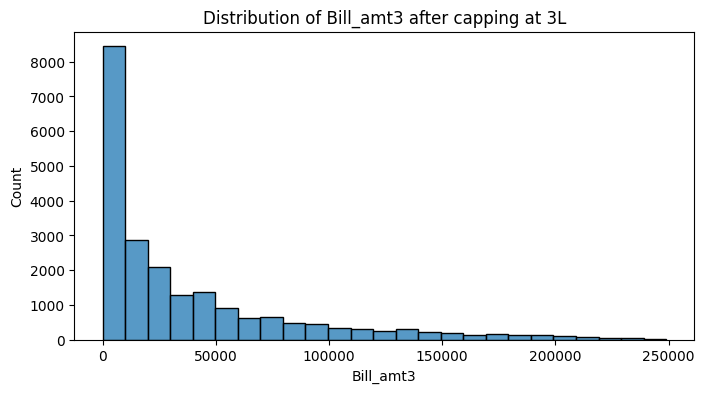

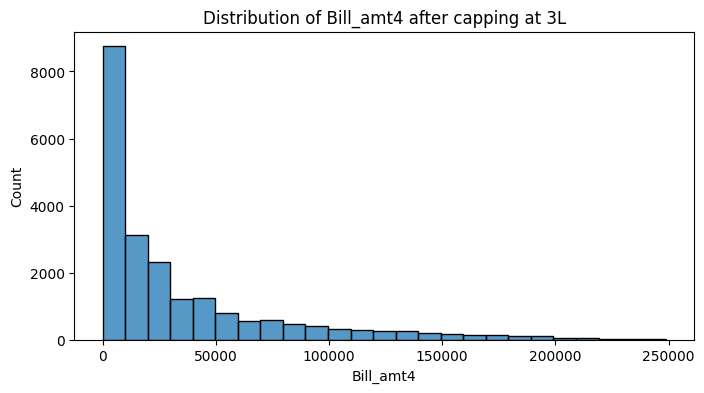

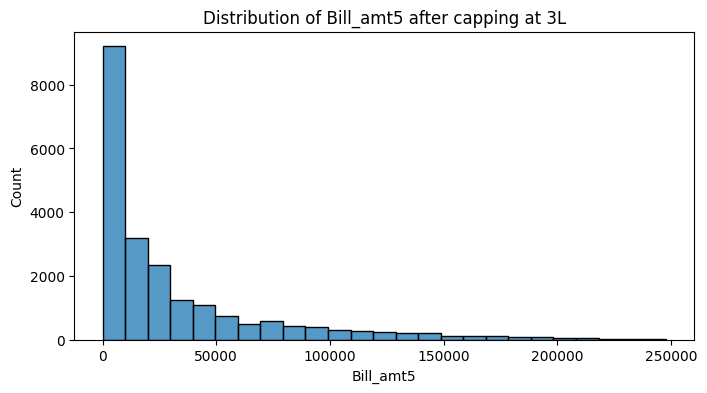

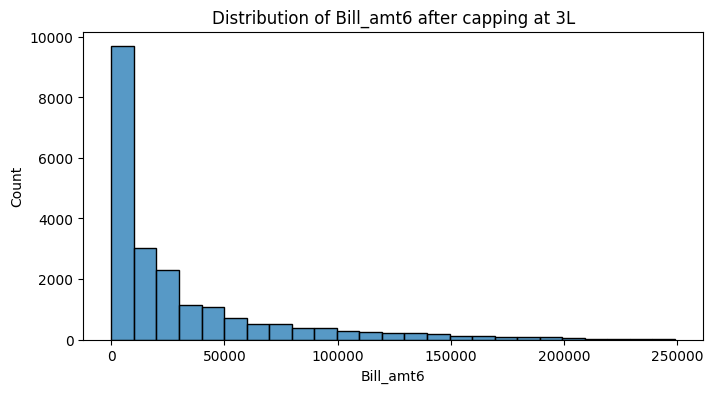

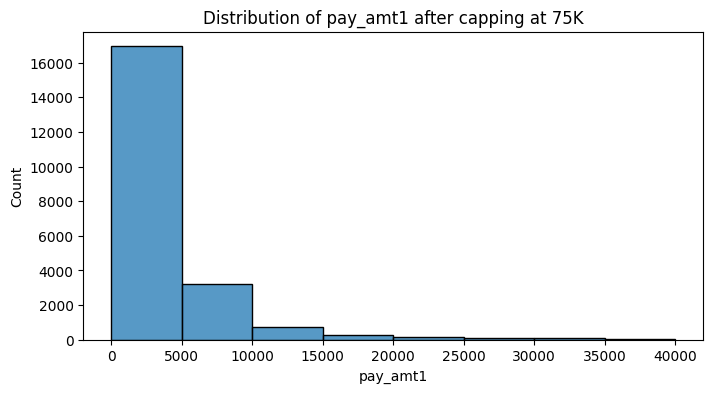

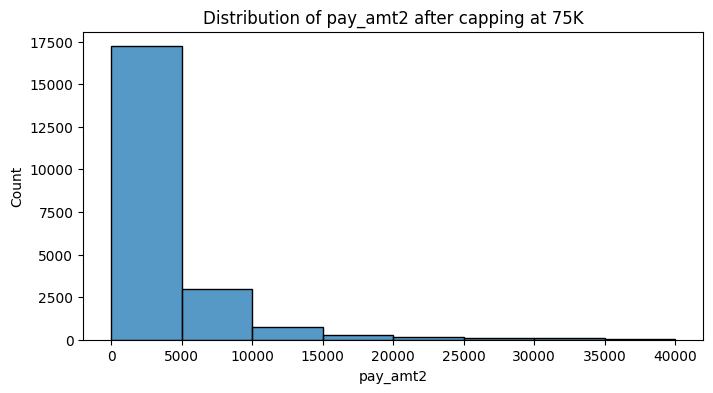

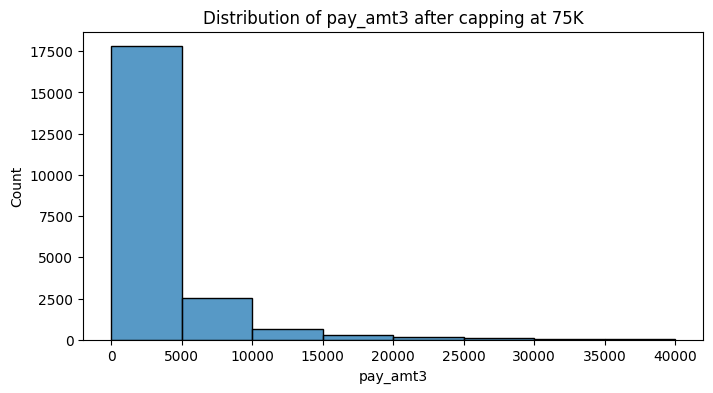

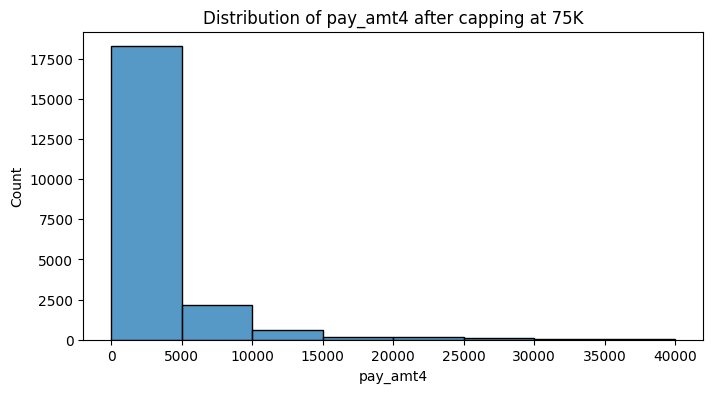

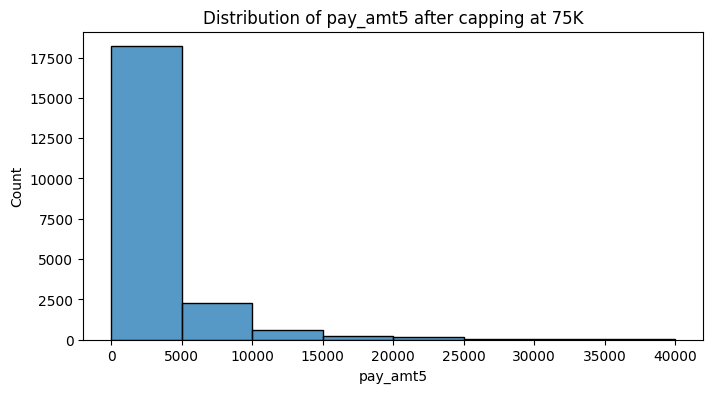

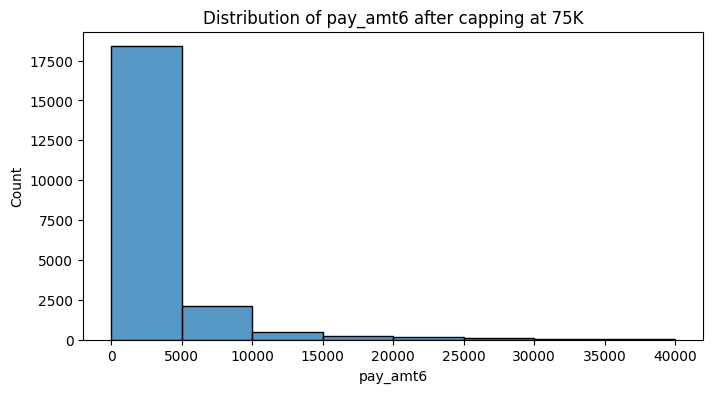

In [571]:
# bill_cols = [f'Bill_amt{i}' for i in range(1, 7)]
# pay_cols = [f'pay_amt{i}' for i in range(1, 7)]

# # plot histograms till 95% of data which means that we are not plotting the outliers
# # for col in bill_cols + pay_cols:
# #     sns.histplot(df[col][df[col] < df[col].quantile(0.99)], kde=True)
# #     plt.title(f'Distribution of {col} (up to 99% quantile)')
# #     plt.show()

# # #drop 1% of the data in bill_cols and pay_cols
# # for col in bill_cols + pay_cols:
# #     df[col] = np.where(df[col] > df[col].quantile(0.95), df[col].quantile(0.95), df[col])
# #     print(f"After capping, {col} shape: {df[col].shape}")

# # # now plot
# for col in bill_cols:
#     sns.histplot(df[col], binwidth=100000)
#     plt.title(f'Distribution of {col} after capping')
#     plt.show()

# for col in pay_cols:
#     sns.histplot(df[col], binwidth=10000)
#     plt.title(f'Distribution of {col} after capping')
#     plt.show()

# #in bills remove 300000+ and in payrols remove 75000+
print("Shape after dropping outliers:", df.shape)

bill_cols = [f'Bill_amt{i}' for i in range(1, 7)]

pay_cols = [f'pay_amt{i}' for i in range(1, 7)]


# Filter rows where all bill values < 300000
bill_condition = (df[bill_cols] < 250000).all(axis=1)


# Filter rows where all pay values < 75000
pay_condition = (df[pay_cols] < 40000).all(axis=1)

# Combine both
df = df[bill_condition & pay_condition]

print("✅ Shape after filtering:", df.shape)



# # ----------- Cap outliers -----------------
# # Bill columns: cap at 300000
# for col in bill_cols:
#     df[col] = 
#     print(f"{col} capped at 300000")



# print("Shape after dropping outliers:", df.shape)

# # Payment columns: cap at 75000
# for col in pay_cols:
#     df[col] = np.where(df[col] > 75000, 75000, df[col])
#     print(f"{col} capped at 75000")

# print("Shape after dropping outliers:", df.shape)

# ----------- Plot histograms -----------------
# Bill columns histogram
for col in bill_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], binwidth=10000)
    plt.title(f'Distribution of {col} after capping at 3L')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# Payment columns histogram
for col in pay_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], binwidth=5000)
    plt.title(f'Distribution of {col} after capping at 75K')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


# see later

After capping, AVG_Bill_amt shape: (20942,)


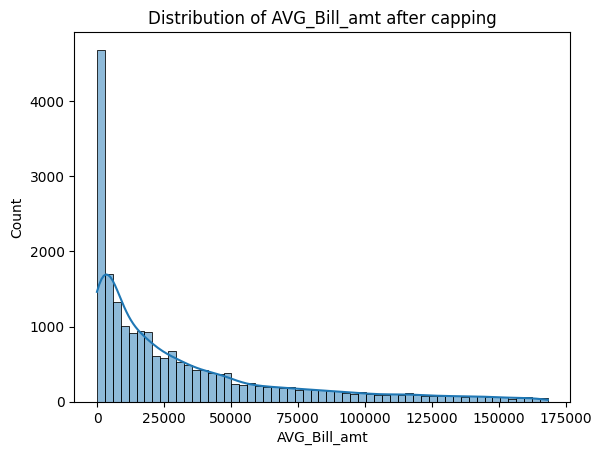

After capping, PAY_TO_BILL_ratio shape: (20405,)


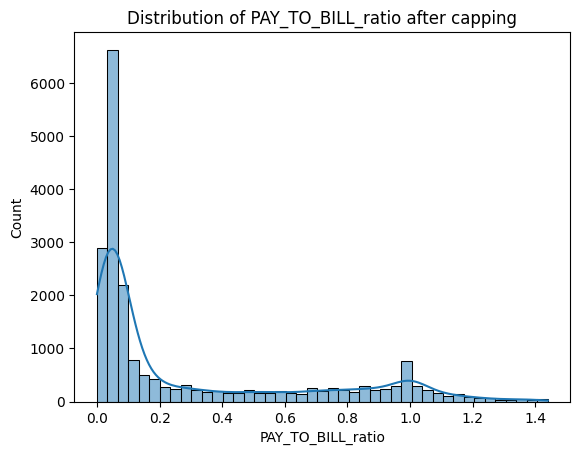

In [572]:
eng_cols = ['AVG_Bill_amt', 'PAY_TO_BILL_ratio']


#plot 90% of data -> leave 5 5 percentiles on both sides
# for col in eng_cols:
#     sns.histplot(df[col][(df[col] > df[col].quantile(0.005)) & (df[col] < df[col].quantile(0.905))], kde=True)
#     plt.title(f'Distribution of {col} (up to 90% quantile)')
#     plt.show()
#     print(f"{col} outliers:", df[col][(df[col] > df[col].quantile(0.90)) | (df[col] < df[col].quantile(0.01))].count())

# #print negatives counts
# for col in eng_cols:
#     print(f"{col} negative counts:", (df[col] < 0).sum())

#drop 1% of the data not in range 0.005 to 0.905 

for col in eng_cols:
    lower = df[col].quantile(0.005)
    upper = df[col].quantile(0.975)
    df = df[(df[col] >= lower) & (df[col] <= upper)]
    df.reset_index(drop=True, inplace=True)
    print(f"After capping, {col} shape: {df[col].shape}")
    # now plot
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col} after capping')
    plt.show()
    
# see later

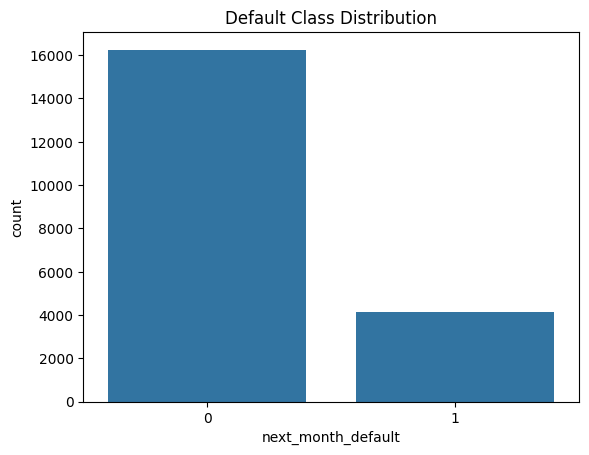

next_month_default
0    0.796716
1    0.203284
Name: proportion, dtype: float64


In [573]:
sns.countplot(x='next_month_default', data=df)
plt.title('Default Class Distribution')
plt.show()

print(df['next_month_default'].value_counts(normalize=True))


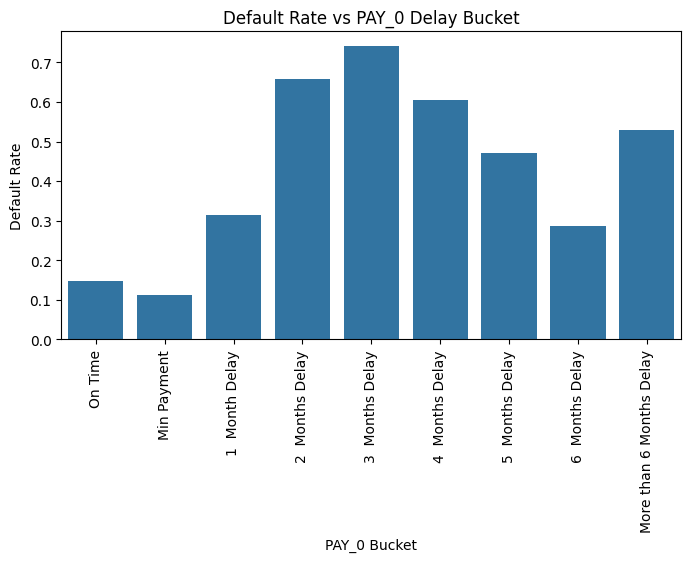

In [574]:
def delay_bucket(x):
    if x <= -1:
        return 'On Time'
    elif x == 0:
        return 'Min Payment'
    elif x== 1:
        return '1  Month Delay'
    elif  x==2:
        return '2  Months Delay'
    elif x==3:
        return '3  Months Delay'
    elif x==4:
        return '4  Months Delay'
    elif x==5:
        return '5  Months Delay'
    elif x==6:
        return '6  Months Delay'
    else:
        return 'More than 6 Months Delay'
    
# Create a new column for PAY_0 delay buckets
df['pay_0_bucket'] = df['pay_0'].apply(delay_bucket)

#Compute default rate for each bucket
grouped = df.groupby('pay_0_bucket')['next_month_default'].agg(['mean', 'count']).reset_index()
grouped.columns = ['pay_0_bucket', 'default_rate', 'count']

# Plot default rate
plt.figure(figsize=(8, 4))
sns.barplot(x='pay_0_bucket', y='default_rate', data=grouped, order=[
    'On Time', 'Min Payment', '1  Month Delay',
    '2  Months Delay', '3  Months Delay', '4  Months Delay',
    '5  Months Delay', '6  Months Delay', 'More than 6 Months Delay'
])
plt.xticks(rotation=90)
plt.title('Default Rate vs PAY_0 Delay Bucket')
plt.ylabel('Default Rate')
plt.xlabel('PAY_0 Bucket')
plt.show()

    



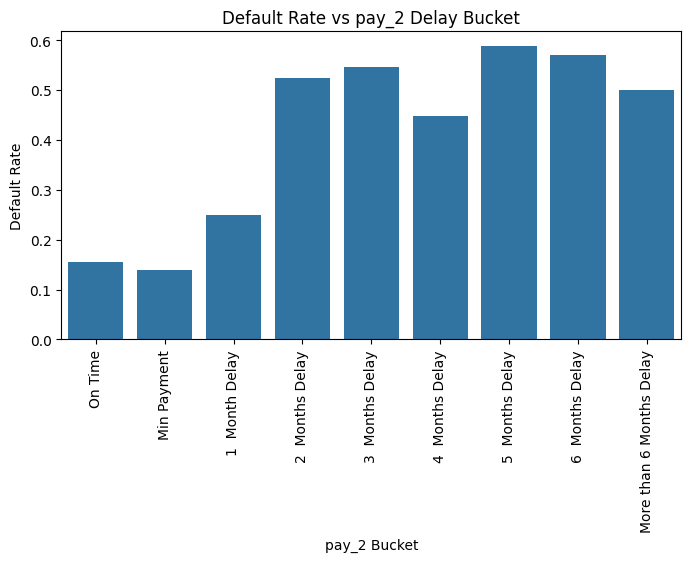

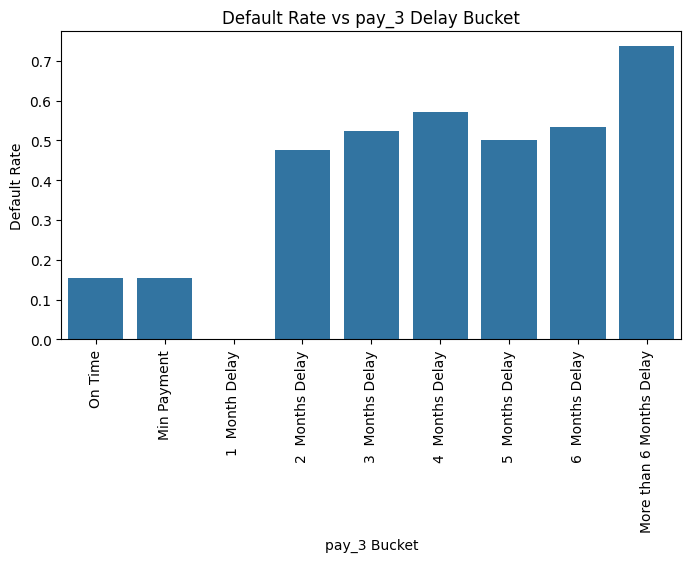

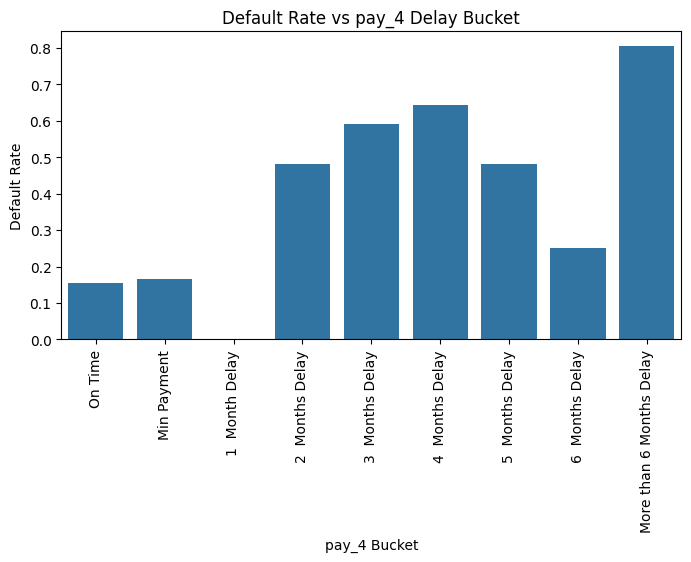

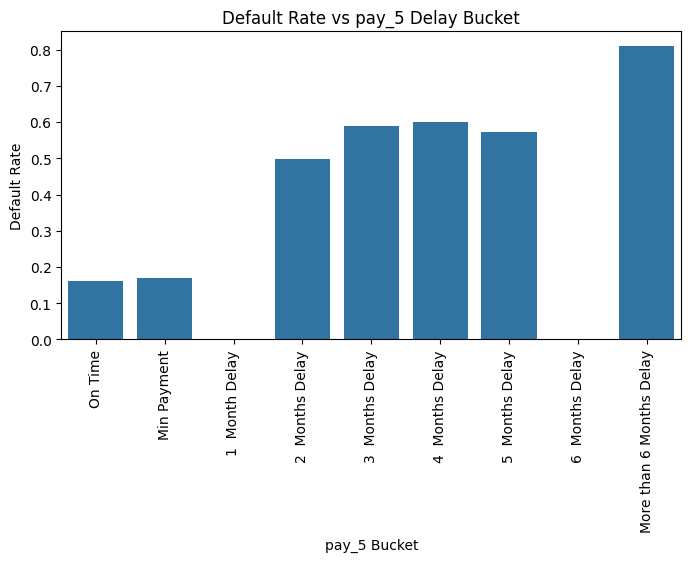

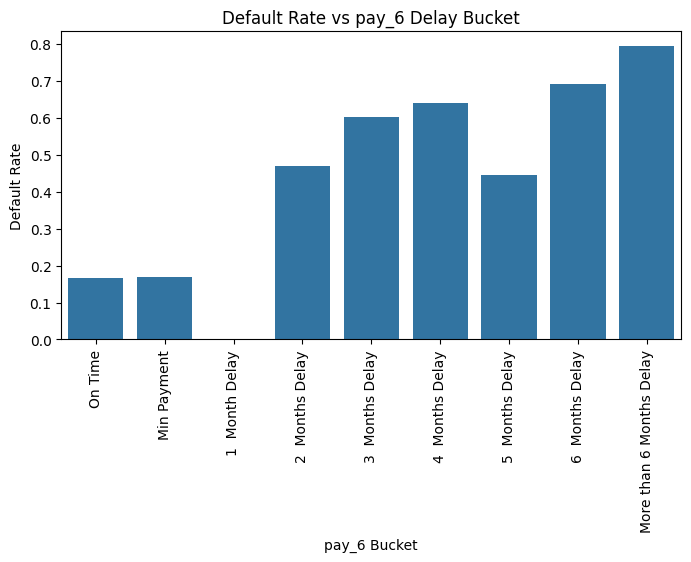

In [575]:
#for pay_2 to pay_6, create buckets and plot default rate
for col in pay_status_cols[1:]:
    df[f'{col}_bucket'] = df[col].apply(delay_bucket)
    grouped = df.groupby(f'{col}_bucket')['next_month_default'].agg(['mean', 'count']).reset_index()
    grouped.columns = [f'{col}_bucket', 'default_rate', 'count']
    
    plt.figure(figsize=(8, 4))
    sns.barplot(x=f'{col}_bucket', y='default_rate', data=grouped, order=[
        'On Time', 'Min Payment', '1  Month Delay',
        '2  Months Delay', '3  Months Delay', '4  Months Delay',
        '5  Months Delay', '6  Months Delay', 'More than 6 Months Delay'
    ])
    plt.xticks(rotation=90)
    plt.title(f'Default Rate vs {col} Delay Bucket')
    plt.ylabel('Default Rate')
    plt.xlabel(f'{col} Bucket')
    plt.show()

C:\Users\krish\AppData\Local\Temp\ipykernel_113168\1964548571.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_age = df.groupby('age_group')['next_month_default'].agg(['mean', 'count']).reset_index()


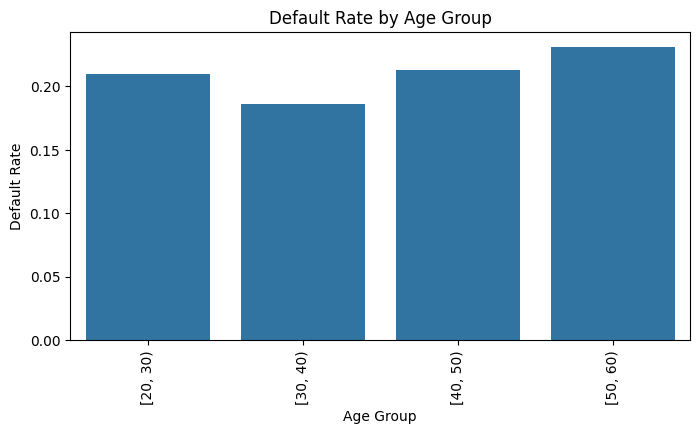

In [576]:
# Compute default rate by age group

age_bins = [20, 30, 40, 50, 60]

#now just plot the age vs default rate in simple way
df['age_group'] = pd.cut(df['age'], bins=age_bins, right=False)
grouped_age = df.groupby('age_group')['next_month_default'].agg(['mean', 'count']).reset_index()
grouped_age.columns = ['age_group', 'default_rate', 'count']
plt.figure(figsize=(8, 4))
sns.barplot(x='age_group', y='default_rate', data=grouped_age)
plt.title('Default Rate by Age Group')
plt.ylabel('Default Rate')
plt.xlabel('Age Group')
plt.xticks(rotation=90)
plt.show()



C:\Users\krish\AppData\Local\Temp\ipykernel_113168\2520740603.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_limit = df.groupby('LIMIT_BAL_bucket')['next_month_default'].agg(['mean', 'count']).reset_index()


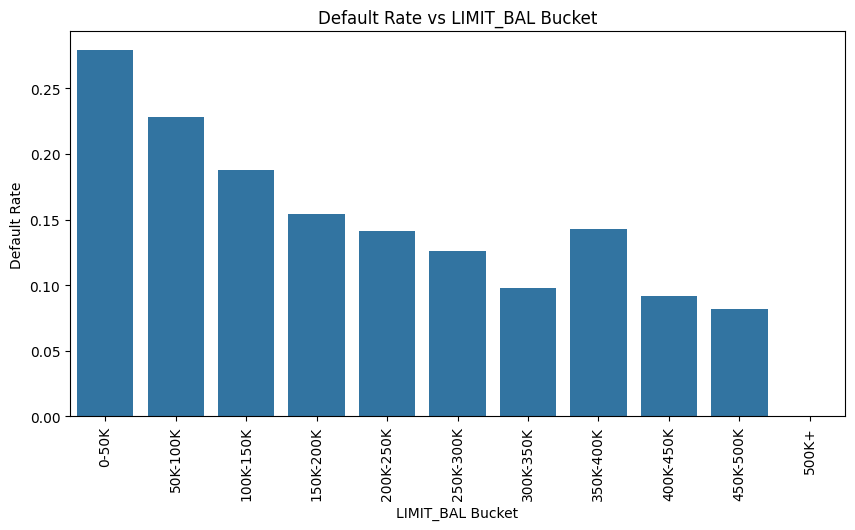

In [577]:
# Create LIMIT_BAL buckets
bins = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 5000000, np.inf]
labels = ['0-50K', '50K-100K', '100K-150K', '150K-200K', '200K-250K', '250K-300K', '300K-350K', '350K-400K', '400K-450K', '450K-500K', '500K+']

df['LIMIT_BAL_bucket'] = pd.cut(df['LIMIT_BAL'], bins=bins, labels=labels)

# Compute default rate for each LIMIT_BAL bucket
grouped_limit = df.groupby('LIMIT_BAL_bucket')['next_month_default'].agg(['mean', 'count']).reset_index()

grouped_limit.columns = ['LIMIT_BAL_bucket', 'default_rate', 'count']
# Plot default rate for LIMIT_BAL buckets
plt.figure(figsize=(10, 5))
sns.barplot(x='LIMIT_BAL_bucket', y='default_rate', data=grouped_limit)
plt.xticks(rotation=90)
plt.title('Default Rate vs LIMIT_BAL Bucket')
plt.ylabel('Default Rate')
plt.xlabel('LIMIT_BAL Bucket')
plt.show()



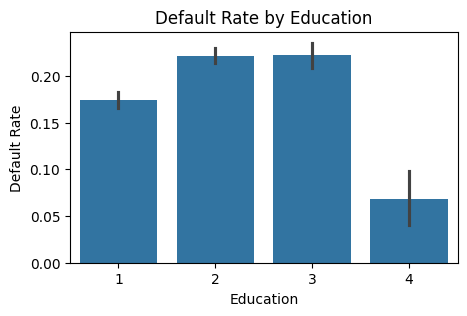

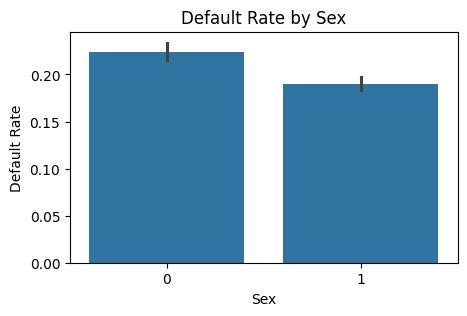

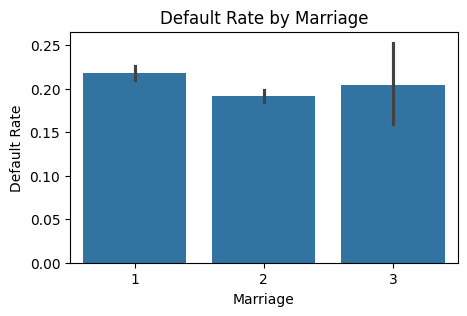

In [578]:
categorical_vars = ['education', 'sex', 'marriage']

for var in categorical_vars:
    plt.figure(figsize=(5, 3))
    sns.barplot(x=var, y='next_month_default', data=df)
    plt.title(f'Default Rate by {var.capitalize()}')
    plt.ylabel('Default Rate')
    plt.xlabel(var.capitalize())
    plt.show()


In [579]:

df.drop(columns=['Customer_ID'], inplace=True)


In [580]:
# Show unique values
for col in ['sex', 'education', 'marriage']:
    print(f"{col}: {df[col].unique()}")


sex: [0 1]
education: [2 1 3 4]
marriage: [2 1 3]


In [581]:
df['sex'] = df['sex'].astype('category')
df['education'] = df['education'].astype('category')
df['marriage'] = df['marriage'].astype('category')
df['next_month_default'] = df['next_month_default'].astype('category')


In [582]:
#print dimensions of the dataset
print("Final dataset shape:", df.shape)


Final dataset shape: (20405, 36)
